Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

###Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


##Load using keras.preprocessing
####Let's load these images off disk using the helpful image_dataset_from_directory utility.

###Preparing Dataset
####Defining some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
##  Train dataset

train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## validation dataset

val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## Test Dataset

test_ds = keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                               seed=123,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb')

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##**Visualizing data**

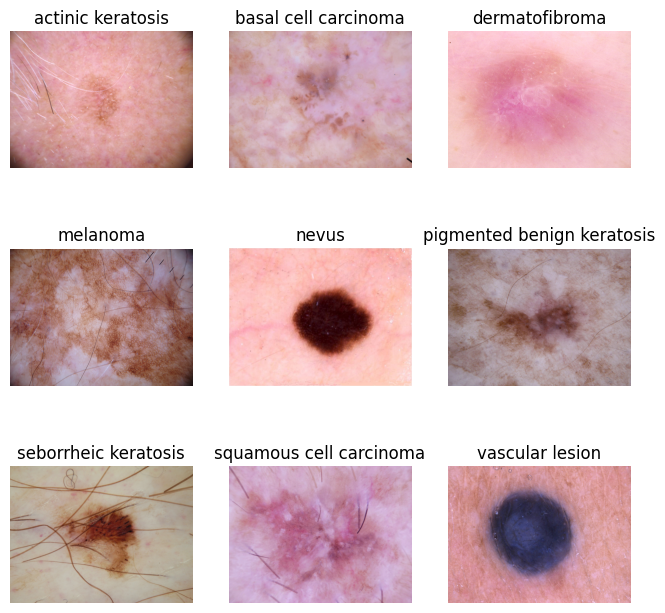

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(list(data_dir_train.glob(class_names[i]+"*/*.jpg"))[0])
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis("off")
#plt.tight_layout()
plt.show()
### your code goes here, you can use training or validation data to visualize

##Optimizing processes using Autotune

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Defining function to visualize the trade off between train and validation accuracy with respect to distinct epochs

In [13]:
def plot_tradeoff(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

##Create the model

####Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [14]:
### Your code goes here
model=keras.Sequential()

model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())


model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

##Compile the model

###Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

###Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 118ms/step - loss: 3.6384 - accuracy: 0.2321 - val_loss: 1.8716 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9339 - accuracy: 0.2824 - val_loss: 1.7100 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6254 - accuracy: 0.4280 - val_loss: 1.6649 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3938 - accuracy: 0.5067 - val_loss: 1.4637 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.2728 - accuracy: 0.5407 - val_loss: 1.4931 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 4s 71ms/step - loss: 1.1992 - accuracy: 0.5798 - val_loss: 1.5410 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 4s 67ms/step - loss: 1.0386 - accuracy: 0.6412 - val_loss: 1.6984 - val_accuracy: 0.4810
Epoch 8/20


##Visualizing training results

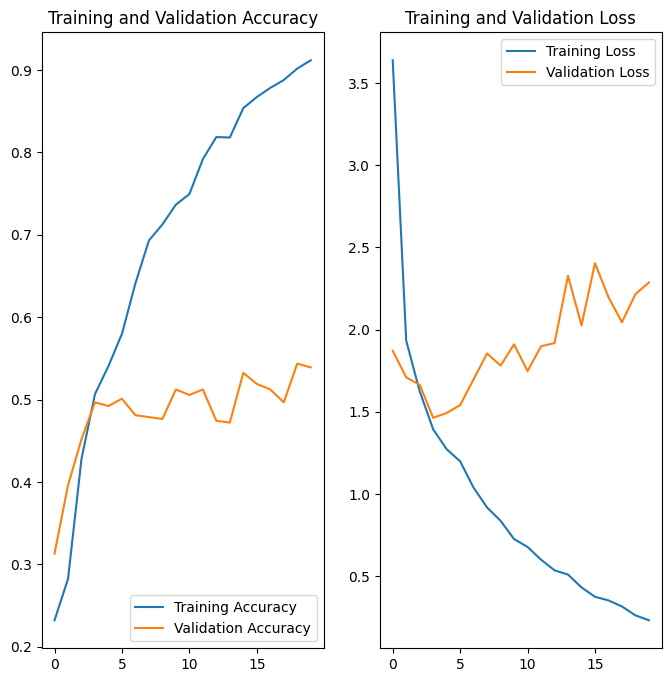

In [18]:
plot_tradeoff(history,epochs)

Some of the important findings from the initial model

* Difference in training accuracy and validation accuracy after 20 epochs indicate the overfitting of model.

* In the initial 4-5 epochs can be place where the model can be stopped learning as the overfitting starts after 4 epochs.

* But stopping at 4-5 has less accuracy around 50% almost a random model.

* Hence, we address overfitting by adding dropout layers and batch normalization layers.

In [19]:
# data augumentation strategy
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model=keras.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer w
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 72ms/step - loss: 2.8088 - accuracy: 0.2974 - val_loss: 1.7700 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6493 - accuracy: 0.4029 - val_loss: 1.7391 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4681 - accuracy: 0.4900 - val_loss: 1.6551 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4114 - accuracy: 0.5006 - val_loss: 1.4153 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3906 - accuracy: 0.5006 - val_loss: 1.3821 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3983 - accuracy: 0.4961 - val_loss: 1.4299 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.2697 - accuracy: 0.5419 - val_loss: 1.3524 - val_accuracy: 0.5459
Epoch 8/20
56

###Visualizing the results

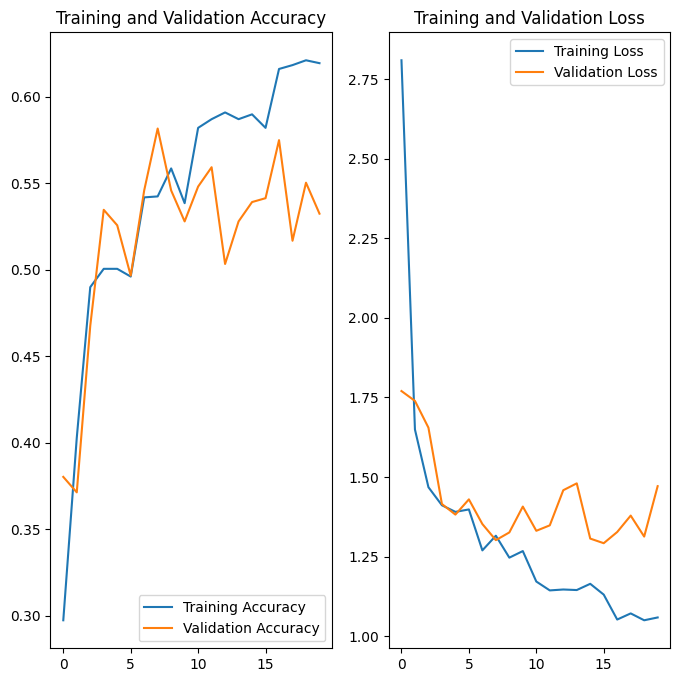

In [23]:
plot_tradeoff(history,epochs)

** Note **

* Data Augmentation layer did address the issue of overfitting till some extent
* Learning of model is yet to be improved.
* Nearby 10 epochs we have optimum loss as well as nearby same train and validation accuracy but again the model is slightly better than random model.
* Hence, we look at the distribution of class and try to address data imbalance if exist.

**Todo**: Find the distribution of classes in the training dataset.

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

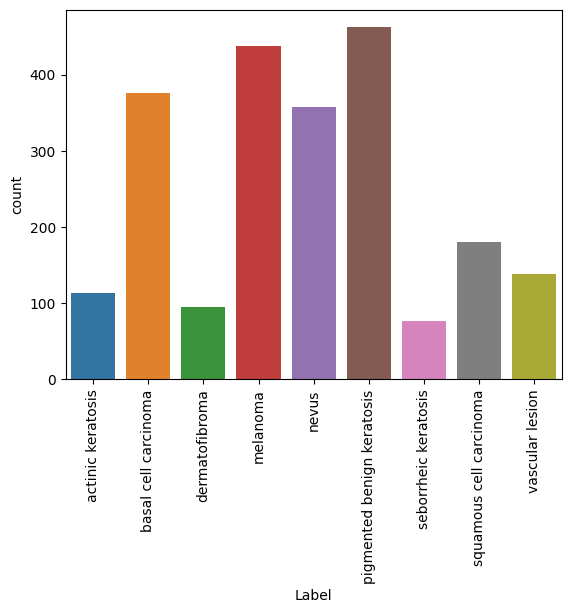

In [24]:
import seaborn as sns
paths =[]
labels = []
for i in class_names:
      for j in data_dir_train.glob(i+'/*.jpg'):
        paths.append(str(j))
        labels.append(i)
dataframe = dict(zip(paths, labels))
original_df = pd.DataFrame(list(dataframe.items()),columns = ['Path','Label'])
sns.countplot(data=original_df,x='Label')
plt.xticks(rotation=90)
plt.show()

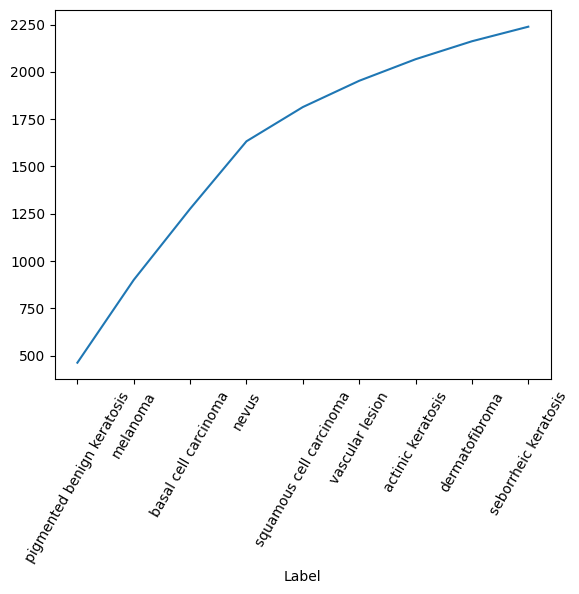

In [25]:
ana = original_df.groupby(by='Label').count()
np.cumsum(ana.Path.sort_values(ascending=False)).plot()
plt.xticks(rotation=60)
plt.show()

Note:

* Pigmented Beign Keratosis, melanoma and basel cell carcinoma accounts for around 60% of the data.

* Seborrheic keratosis has the least amount of images.
* Seborrheic constitute of around 4% data only where as 22% resuting in huge data imbalance.
* In an ideal state (uniform distribution) we should have around 250 images for each class.
* Hence, we address the issue of data imbalance using augmentor package

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3B88CC2170>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C100E5870>: 100%|██████████| 500/500 [00:25<00:00, 19.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C1025D840>: 100%|██████████| 500/500 [00:21<00:00, 23.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3B2CCCA200>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C101F8D60>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C1025D840>: 100%|██████████| 500/500 [00:18<00:00, 26.46 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3C103CEB60>: 100%|██████████| 500/500 [00:44<00:00, 11.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3B2CE86C80>: 100%|██████████| 500/500 [00:18<00:00, 26.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C11C10160>: 100%|██████████| 500/500 [00:20<00:00, 24.39 Samples/s]


In [28]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


###see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [33]:
#label count.
df2['Label'].value_counts()

melanoma                      500
basal cell carcinoma          500
nevus                         500
actinic keratosis             500
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
pigmented benign keratosis    500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [35]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [36]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create model

In [37]:
# CNN Model
model=keras.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [38]:
#Compilation of model
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

Training the model on resampled data

In [39]:
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
169/169 [==============================] - 43s 241ms/step - loss: 2.3708 - accuracy: 0.3448 - val_loss: 1.6865 - val_accuracy: 0.3920
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 1.5033 - accuracy: 0.4366 - val_loss: 1.4387 - val_accuracy: 0.4491
Epoch 3/30
169/169 [==============================] - 32s 184ms/step - loss: 1.3810 - accuracy: 0.4803 - val_loss: 1.3113 - val_accuracy: 0.4833
Epoch 4/30
169/169 [==============================] - 31s 176ms/step - loss: 1.2860 - accuracy: 0.5085 - val_loss: 1.2776 - val_accuracy: 0.5212
Epoch 5/30
169/169 [==============================] - 32s 187ms/step - loss: 1.2149 - accuracy: 0.5369 - val_loss: 1.1776 - val_accuracy: 0.5516
Epoch 6/30
169/169 [==============================] - 33s 191ms/step - loss: 1.1551 - accuracy: 0.5655 - val_loss: 1.1937 - val_accuracy: 0.5627
Epoch 7/30
169/169 [==============================] - 31s 179ms/step - loss: 1.1229 - accuracy: 0.5701 - val_loss: 1.0789 - val_ac

###Visualizing model results

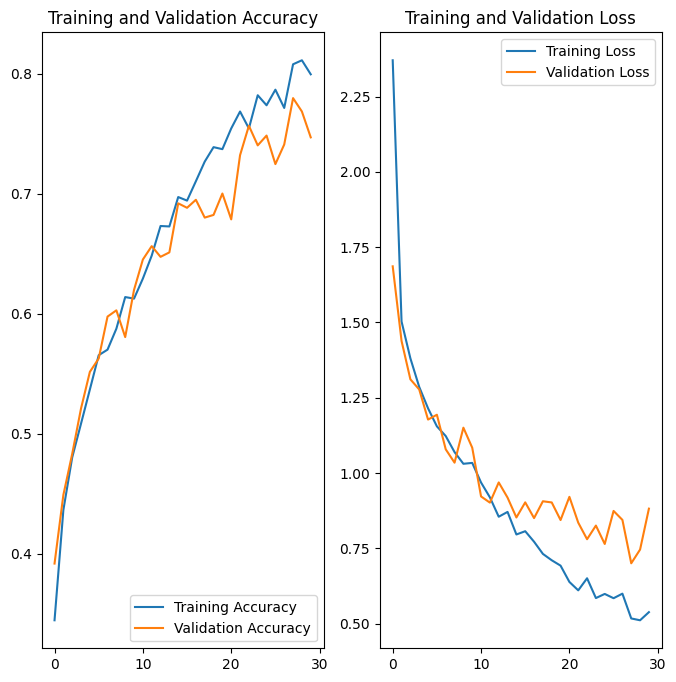

In [40]:
plot_tradeoff(history,epochs)

###Observations
* Resampling using augmentor pipeline actually solved the problem of overfitting.
* It also increased the accuracy of the model to about 72%.